In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi, cos, sin, acos, sqrt
%matplotlib inline

<code>Map</code> est un objet.
<code>Map.beings_list</code> est une liste contenant tous les individus <code>Being</code>, sa longueur est donc de quelques milliers.
Chaque objet <code>Being</code> contient plusieurs paramètres : <code>move_range</code>, <code>satiation</code>, <code>type_id</code> etc.

Pour optimiser le programme nous utiliserons <code>beings_map</code>:

<code>beings_map</code> est un <code>numpy.array</code> de taille : (width,height).
<code>beings_map[i][j]</code> est un  set d'indices des individus issu de <code>beings_list</code> avec leurs <code>positions</code> contenu dans un carré de côté 1, d'origine coin supérieur gauche : (i,j)

<code>free_indexes_set</code> est l'ensemble des indices libre.

<code>plant_count_map[i][j]</code> = le nombre de plantes contenues dans le carré de côté 1, d'origine coin supérieur gauche : (i,j)

In [2]:
class Being:
    def __init__(self,
                 species,
                 position,
                 map_shape):
        """
        self (objet)
        species -> tuple(float,number,number,set(int),color,number,number,number,float,float,int)
        map_shape tuple(int,int) 
        
        Initialisation d'un objet : Being
        """
        (
            self.move_range,
            self.satiation,
            self.type_id,
            self.edible_species_id,
            self.color,
            self.reproduction_cooldown,
            self.reproduction_threshold,
            self.hunger_threshold,
            self.direction_change_probability,
            self.random_movement_portion,
            self.prey_search_range
        ) = species
        self.reproduction_current_cooldown = np.random.rand() * self.reproduction_cooldown
        self.set_position(position, map_shape)
        self.current_direction = self.move_range * (np.random.rand(2) - 1/2)
        self.is_dead = False
        self.position_in_list = None
    
    def set_position_in_list(self, position):
        """
        position -> int
        position dans la Map.being.list 
        
        Change la variable depuis la position dans Being
        """
        self.position_in_list = position
    
    def get_position_in_list(self):
        if self.position_in_list == None:
            raise RuntimeError("Position in list not initialized")
        return self.position_in_list
    
    def is_plant(self):
        return len(self.edible_species_id) == 0
    
    def get_int_position(self):
        """
        Transforme la position (i,... ; j,...) en -> int (i, j)
        """
        return tuple(self.position.astype(int))
    
    def get_position(self):
        return tuple(self.position)
    
    def format_position(self, shape, position):
        """
        Fonction pour modéliser un monde de Tore, qui change la position d'un individu
        s'il dépasse les extrémités
        """
        position = position.copy()
        if (position[0] >= shape[0]):
            position[0] -= shape[0]
        if (position[1] >= shape[1]):
            position[1] -= shape[1]
        if (position[0] < 0):
            position[0] += shape[0]
        if (position[1] < 0):
            position[1] += shape[1]
        return position
    
    def modify_position(self, addition, map_shape, change_position=True):
        """
        Lorsque change_position=True, change la position.
        Sinon on renvoie sa position + addition
        """
        if change_position:
            self.position = self.format_position(map_shape, self.position + addition)
            return
        return tuple(self.format_position(map_shape, self.position + addition).astype(int))
        
    def set_position(self, new_position, map_shape):
        self.position = self.format_position(map_shape, new_position)
        
    def get_species(self, evolution_rate=0):
        """
        23/02/17 : fonction d'évolution des paramètres non utilisé pour l'instant
        """
        if evolution_rate == 0:
            return (
                       self.move_range,
                       self.satiation,
                       self.type_id,
                       self.edible_species_id.copy(),
                       self.color,
                       self.reproduction_cooldown,
                       self.reproduction_threshold,
                       self.hunger_threshold,
                       self.direction_change_probability,
                       self.random_movement_portion,
                       self.prey_search_range,
                   )
        else:
            return (
                       self.move_range * (1 + 2 * evolution_rate * (np.random.rand()-0.5)),
                       self.satiation,
                       self.type_id,
                       self.edible_species_id.copy(),
                       self.color,
                       self.reproduction_cooldown * (1 + 2 * evolution_rate * (np.random.rand()-0.5)),
                       self.reproduction_threshold * (1 + 2 * evolution_rate * (np.random.rand()-0.5)),
                       self.hunger_threshold * (1 + 2 * evolution_rate * (np.random.rand()-0.5)),
                       self.direction_change_probability,
                       self.random_movement_portion,
                       self.prey_search_range,
                   )

In [3]:
class Map:
    def __init__(self, beings_count, width, height, species_list):
        """
        """
        self.plant_count_map = np.zeros((width, height))
        self.beings_map = np.zeros((width, height)).astype(set)
        for i in range(width):
            for j in range(height):
                self.beings_map[i, j] = set()
        self.beings_list = []
        self.free_indexes_set = set()
        for i in range(len(beings_count)):
            for j in range(beings_count[i]):
                self.create_being(species_list[i], True)
                
    def create_being(self, species, random_position, position=None):
        if random_position:
            position = np.array((np.random.rand() * self.beings_map.shape[0],
                    np.random.rand() * self.beings_map.shape[1]))
        else:
            position = position.copy()
        being = Being(species,
                      position,
                      self.beings_map.shape)
        if (len(self.free_indexes_set) == 0):
            being.set_position_in_list(len(self.beings_list))
            self.beings_list.append(being)
        else:
            being.set_position_in_list(self.free_indexes_set.pop())
            self.beings_list[being.get_position_in_list()] = being
        self.add_being_to_map(being)
            
    def remove_being_from_map(self, being):
        self.beings_map[being.get_int_position()].remove(being.get_position_in_list())
        if being.is_plant():
            self.plant_count_map[being.get_int_position()] -= 1
    
    def add_being_to_map(self, being):
        self.beings_map[being.get_int_position()].add(being.get_position_in_list())
        if being.is_plant():
            self.plant_count_map[being.get_int_position()] += 1
        
    def move_being(self, being, roam=True, angle=0):
        if roam:
            angle = np.random.rand() * 2 * pi
            if np.random.rand() < being.direction_change_probability:
                being.current_direction = being.move_range * np.array((cos(angle), sin(angle)))
        self.remove_being_from_map(being)
        if roam:
            being.modify_position(
                                     (
                                         cos(angle) * being.move_range * being.random_movement_portion
                                         + being.current_direction[0] * (1 - being.random_movement_portion),

                                         sin(angle) * being.move_range * being.random_movement_portion
                                         + being.current_direction[1] * (1 - being.random_movement_portion)
                                     ),
                                     self.beings_map.shape
                                 )
        else:
            being.modify_position(
                                     (
                                         cos(angle) * being.move_range,
                                         sin(angle) * being.move_range,
                                     ),
                                     self.beings_map.shape
                                 )
        self.add_being_to_map(being)
        
    def iterate_ring(self, being, radius):
        """
        generateur qui retourne les cellules de carrée de coté 2*raduis + 1, centré sur la position de being
        """
        for i in range(-radius, radius + 1):
            current_cell_position = being.modify_position((i, -radius), self.beings_map.shape, change_position=False)
            yield current_cell_position, (i, -radius)
        for i in range(-radius, radius + 1):
            current_cell_position = being.modify_position((i, radius), self.beings_map.shape, change_position=False)
            yield current_cell_position, (i, radius)
        for i in range(-radius + 1, radius):
            current_cell_position = being.modify_position((-radius, i), self.beings_map.shape, change_position=False)
            yield current_cell_position, (-radius, -i)
        for i in range(-radius + 1, radius):
            current_cell_position = being.modify_position((radius, i), self.beings_map.shape, change_position=False)
            yield current_cell_position, (radius, -i)
        
    def move_towards_prey(self, being):
        if being.prey_search_range <= 1:
            return False
        for radius in range(1, being.prey_search_range + 1):
            for position, displacement in self.iterate_ring(being, radius):
                for prey_index in self.beings_map[position]:
                    if self.beings_list[prey_index].type_id in being.edible_species_id and not self.beings_list[prey_index].is_dead:
                        angle = acos(displacement[0] / sqrt(displacement[0] ** 2 + displacement[1] ** 2))
                        if displacement[1] < 0:
                            angle = -angle
                        self.move_being(being, roam=False, angle=angle)
                        return True
        return False
                        
        
        
    def delete_being(self, being):
        self.remove_being_from_map(being)
        self.free_indexes_set.add(being.get_position_in_list())
        being.is_dead = True
    
    def eat(self, being, prey):
        being.satiation += prey.satiation / 2
        self.delete_being(prey)
    
    def find_and_eat(self, being):
        for i in range(-1, 2):
            for j in range(-1, 2):
                current_cell_position = being.modify_position((i,j), self.beings_map.shape, change_position=False)
                for being_index in self.beings_map[current_cell_position]:
                    if (not self.beings_list[being_index].is_dead
                            and being.get_position_in_list() != self.beings_list[being_index].get_position_in_list()
                            and self.beings_list[being_index].type_id in being.edible_species_id
                            ):
                        self.eat(being, self.beings_list[being_index])
                        return True
        return False
    
    def reproduction(self, being):
        being.reproduction_current_cooldown = being.reproduction_cooldown * (np.random.rand() + 0.5)
        being.satiation /= 2
        if being.is_plant():
            self.create_being(being.get_species(), True)
        else:
            position = being.get_position() + np.random.rand(2) - 0.5
            self.create_being(being.get_species(), False, position=position)
    
    def iterate_being(self, being):
        if being.reproduction_current_cooldown > 0:
            being.reproduction_current_cooldown -= 1
        if being.is_plant():
            being.satiation += max(1 / self.plant_count_map[being.get_int_position()] - 0.3, 0)
        else:
            being.satiation -= 1
        if (being.satiation <= 0):
            self.delete_being(being)
            return
        if (being.satiation < being.hunger_threshold and not being.is_plant()):
            if self.find_and_eat(being):
                return
            else:
                if self.move_towards_prey(being):
                    return
        if (being.satiation > being.reproduction_threshold
                and being.reproduction_current_cooldown <= 0):
            self.reproduction(being)
        if not being.is_plant():
            self.move_being(being)

    def iteration(self):
        for being in self.beings_list:
            if not being.is_dead:
                self.iterate_being(being)

In [36]:
species = [(0.05, 130, 0, {2}, (0, 0, 1, 1), 200, 101, 100, 0.01, 0.15, 0),
           (0.15, 130, 1, {0}, (1, 0, 0, 1), 400, 151, 150, 0.01, 0.15, 3),
           (0, 10, 2, set(), (0, 0.8, 0.2, 1), 50, 40, 1000, 0.01, 0.15, 0),
          ]

the_map = Map([100, 5, 1500], 50, 50, species)

Schéma animé de monde:

<IPython.core.display.Javascript object>


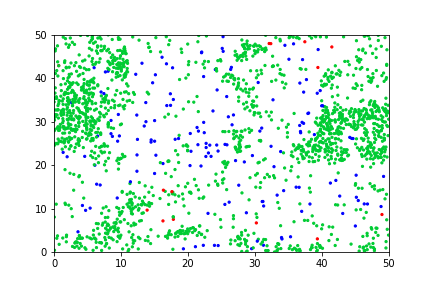

In [35]:
%matplotlib notebook

import numpy as np
import matplotlib.animation as animation

plt.close('all')


fig = plt.figure(5)
ax = plt.axes(xlim=(0, the_map.beings_map.shape[0]), ylim=(0, the_map.beings_map.shape[1]))
scat = ax.scatter([], [], s=60)
#plt.xticks([]), plt.yticks([])


def init():
    scat.set_offsets([])

def update(*args):
    positions = []
    colors = []
    for i in range(len(the_map.beings_list)):
        if not the_map.beings_list[i].is_dead:
            positions.append(the_map.beings_list[i].get_position())
            colors.append(the_map.beings_list[i].color)
    scat.set_offsets(positions)
    scat.set_color(colors)
    scat.set_sizes(5 * np.ones(len(the_map.beings_list)))
    the_map.iteration()
    return scat,

anim = animation.FuncAnimation(fig, update, init_func=init, frames=range(100),
                               interval=50)
plt.show()

Fonction <code>get_population</code> retourne une liste de nombre d'individus de chaque espèce

In [8]:
def get_population(beings_list):
    result = {}
    for being in beings_list:
        if being.is_dead:
            continue
        if not being.type_id in result.keys():
            result[being.type_id] = 1
        else:
            result[being.type_id] += 1
    return result

Fonction <code>draw_population</code> qui faire une graphe de dynamique de population. 

In [6]:
def draw_population(beings_map,
                    beings_list,
                    free_indexes_set,
                    plant_count_map,
                    iteration_number,
                    iterations_per_step,
                    species_to_draw=None,
                    stop_on_extinction=False):
    graphics = {}
    inital_population = get_population(beings_list)
    population = get_population(beings_list)
    for type in inital_population:
        graphics[type] = []
    current_iteration = 0
    extinct = False
    while current_iteration < iteration_number and not (stop_on_extinction and extinct):
        for type in inital_population:
            if not type in population:
                graphics[type].append(0)
                extinct = True
            else:
                graphics[type].append(population[type])
        for i in range(iterations_per_step):
            the_map.iteration()
        population = get_population(beings_list)
        current_iteration += 1
    plt.close('all')
    fig = plt.figure(figsize=(12, 6))
    for type in inital_population:
        if not species_to_draw == None and not type in species_to_draw:
            continue
        subplot = plt.subplot((len(inital_population.keys()) // 2 + 1) * 100 + 20 + 1 + type)
        subplot.set_xlim((0, iteration_number))
        subplot.plot(graphics[type])
    plt.show()
    fig = plt.figure(figsize=(12, 6))
    for type in inital_population:
        if not species_to_draw == None and not type in species_to_draw:
            continue
        subplot = plt.subplot(111)
        subplot.set_xlim((0, iteration_number))
        subplot.semilogy(graphics[type])
    plt.show()

<IPython.core.display.Javascript object>


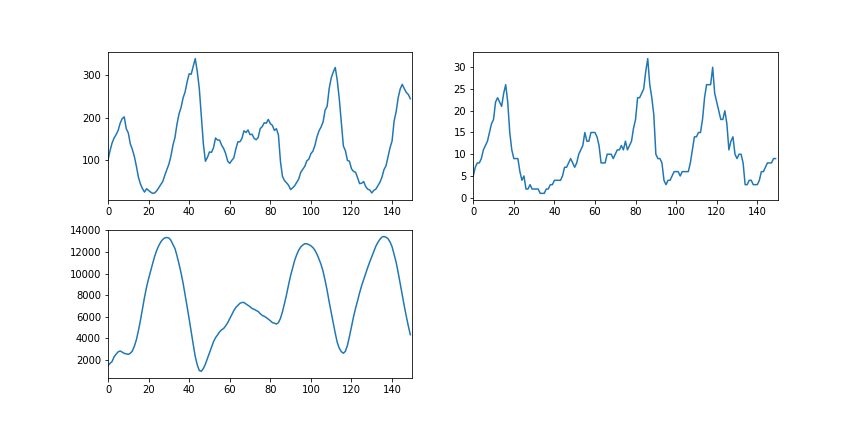

<IPython.core.display.Javascript object>


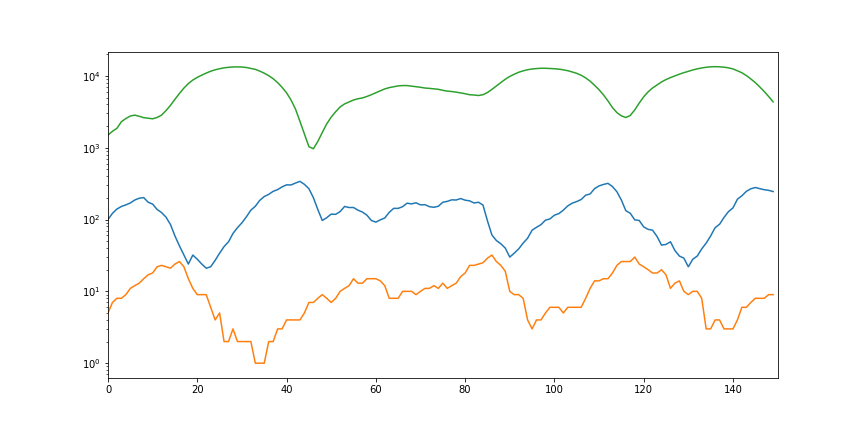

In [37]:
draw_population(the_map.beings_map,
                the_map.beings_list,
                the_map.free_indexes_set,
                the_map.plant_count_map,
                150,
                60,
                species_to_draw={0, 1, 2},
                stop_on_extinction=True)

Fonctions pour trouver de paramètres qui entraîne la survie de toutes les espèces

In [31]:
def survival_simulation(the_map, species_count):
    the_map.iteration()
    if len(get_population(the_map.beings_list)) < species_count:
        return False
    return True

In [32]:
def survival_tests(file_name,
                   species,
                   map_size,
                   max_iterations,
                   test_count,
                   inital_beings_number_bounds,
                   simulations_per_test=1,
                   change_satiation_threshold=True,
                   change_reproduction_threshold=True,
                   change_reproduction_cooldown=True,
                   change_inital_satiation=True,
                   change_hunt_range=False):
    tested_species = np.concatenate(np.array(species)[:, [1, 5, 6, 7]])
    tested_species = np.tile(tested_species, (test_count * simulations_per_test, 1))
    results = []
    species_count = 0
    for test_number in range(test_count):
        current_species = np.array(species.copy())
        if change_satiation_threshold:
            current_species[:, 7] *= (0.5 + 2 * np.random.rand(current_species.shape[0]))
        if change_reproduction_threshold:
            current_species[:, 6] *= (0.5 + 2 * np.random.rand(current_species.shape[0]))
        if change_satiation_threshold:
            current_species[:, 5] *= (0.5 + 2 * np.random.rand(current_species.shape[0]))
        if change_inital_satiation:
            current_species[:, 1] *= (0.5 + 2 * np.random.rand(current_species.shape[0]))
        inital_count = []
        for bounds in inital_beings_number_bounds:
            inital_count.append(np.random.randint(bounds[0], bounds[1] + 1))
            if inital_count[-1] != 0 and test_number == 0:
                species_count += 1
        for simulation in range(simulations_per_test):
            finished = False
            the_map = Map(inital_count, map_size, map_size, current_species)
            tested_species[test_number * simulations_per_test + simulation] = np.concatenate(current_species[:, [1, 5, 6, 7]])
            for iteration in range(max_iterations):
                if not survival_simulation(the_map, species_count):
                    results.append([False])
                    finished = True
                    break
            else:
                results.append([True])
            if finished:
                break
    tested_species = np.hstack((tested_species, results))
    columns = []
    for current_species in range(len(species)):
        columns += [
            "species " + str(current_species) + " inital satiation",
            "species " + str(current_species) + " satiation threshold",
            "species " + str(current_species) + " reproduction cooldown",
            "species " + str(current_species) + " reproduction threshold",
        ]
    columns.append("result")
    pd.DataFrame(data=tested_species, columns=columns).to_csv(file_name, index=False)
    return tested_species, results       

In [33]:
survival_tests("data/tests.csv",
               species,
               50,
               max_iterations=100,
               test_count=3,
               inital_beings_number_bounds=[(300, 700), (2, 6), (500, 3000)],
               simulations_per_test=1,
               change_satiation_threshold=False,
               change_reproduction_threshold=False,
               change_reproduction_cooldown=False,
               change_inital_satiation=False,
               change_hunt_range=False)

(array([[130, 200, 101, 100, 130, 400, 151, 150, 10, 50, 40, 1000, True],
        [130, 200, 101, 100, 130, 400, 151, 150, 10, 50, 40, 1000, True],
        [130, 200, 101, 100, 130, 400, 151, 150, 10, 50, 40, 1000, True]], dtype=object),
 [[True], [True], [True]])

In [34]:
pd.read_csv("data/tests.csv")

,species 0 inital satiation,species 0 satiation threshold,species 0 reproduction cooldown,species 0 reproduction threshold,species 1 inital satiation,species 1 satiation threshold,species 1 reproduction cooldown,species 1 reproduction threshold,species 2 inital satiation,species 2 satiation threshold,species 2 reproduction cooldown,species 2 reproduction threshold,result
0,130,200,101,100,130,400,151,150,10,50,40,1000,True
1,130,200,101,100,130,400,151,150,10,50,40,1000,True
2,130,200,101,100,130,400,151,150,10,50,40,1000,True
